In [52]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from IPython.display import display, Latex
import pandas as pd
import random as rd

plt.style.use('ggplot')

### Calculate $\pi$

In [55]:
def pi(n):
    n1 = np.random.rand(n) * 2
    n2 = np.random.rand(n) * 2
    in_area = ((n1-1)**2 + (n2-1)**2 <=1).astype(int)

    #plot
    col = np.where(in_area==1,'Indianred','gray')
    fig, ax = plt.subplots(figsize=(5,5))
    ax.scatter(n1, n2, c=col, s=1)
    circle = plt.Circle((1, 1), 1, color='k', fill=False)
    ax.add_artist(circle)
    plt.xlim(0, 2)
    plt.ylim(0, 2)
    display(Latex(rf'$\pi$ is {(np.sum(in_area) / n) * 4}'))

<IPython.core.display.Latex object>

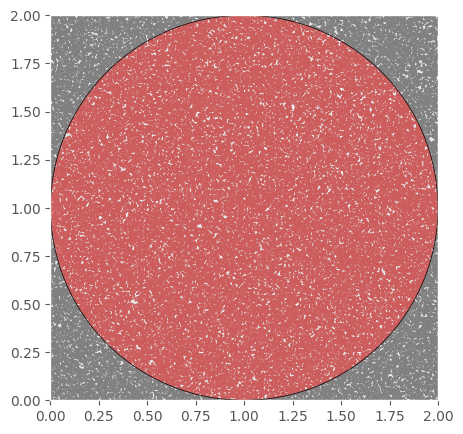

In [60]:
pi(100000)

### Buffon Needle

Text(0.01, 0.9, 'Estimated value of pi: 2.985, Actual Value of pi: 3.142, Diff =-0.157')

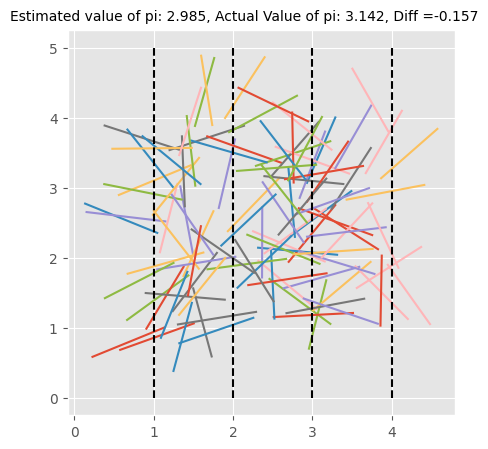

In [54]:
sample_size = 100
sig_figs = 10000

fig = plt.figure(figsize=[5, 5])
fig.subplots_adjust(hspace=.4)
board = fig.add_subplot(1, 1, 1)
needles = pd.DataFrame({'x_point':[],'y_point':[],'x_end_point':[],'y_end_point':[],'crossed_line':[]})

for n in range(0,sample_size):
    x = rd.randrange(sig_figs,(4*sig_figs))/ sig_figs
    y = rd.randrange(sig_figs, (4*sig_figs)) / sig_figs
    theta = rd.randrange(0,360*sig_figs) / sig_figs
    x_end = x + np.sin(np.rad2deg(theta))
    y_end = y + np.cos(np.rad2deg(theta))
    board.plot([x, x_end], [y, y_end])
    if abs(int(x)-int(x_end))==1:
        crossed = True
    else:
        crossed = False
    new_needle = [x,y,x_end,y_end,crossed]
    needles.loc[n]=new_needle

yard_lines = [[[1,1],[0,5]],[[2,2],[0,5]],[[3,3],[0,5]],[[4,4],[0,5]]]
for n in range(0,4):
    board.plot(yard_lines[n][0],yard_lines[n][1],'k--')

crossed_count = len(needles[needles['crossed_line']==True])
pi_est = (2*sample_size)/crossed_count
diff=pi_est-np.pi
text = 'Estimated value of pi: {:.3f}, Actual Value of pi: {:.3f}, Diff ={:.3f}'.format(pi_est, np.pi, diff)
fig.text(.01, .9, text)


### Option Pricing

In [74]:
def call(ST,K):
    return np.maximum(ST-K, 0)

def put(ST,K):
    return np.maximum(K-ST, 0)

def BS(S, K, T, r, sigma, option):
    d1 = (np.log(S/K) + (r+0.5*sigma**2)*T) / (sigma*T**0.5)
    d2 = d1 - (sigma*T**0.5)
    if option == 'call':
        return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option == 'put':
        return -S*norm.cdf(-d1) + K*np.exp(-r*T)*norm.cdf(-d2)
    
def monte_carlo_option(S, K, T, r, sigma, N, option, method=None, seed=1234):
    np.random.seed(seed)
    payoff = {'call': call, 'put': put}[option]
    if method == 'ordinary':
        eps = np.random.normal(0, 1, N)
    elif method == 'antithetic':
        eps = np.random.normal(0, 1, int(N/2))
        eps = np.concatenate((eps, -eps))
    ST = S * np.exp((r-0.5*sigma**2)*T + sigma*T**0.5*eps)
    C_t = payoff(ST, K)
    return np.mean(C_t), np.std(C_t)/N**0.5


Pricing Value
-----------------
BS: 8.433
Monte Carlo mean: 8.542
Monte Carlo std: 0.095
Monte Carlo (A) mean: 8.479
Monte Carlo (A) std: 0.095
Error Performance
               0           1            2            3            4  \
N     100.000000  500.000000  1000.000000  2000.000000  5000.000000   
MC      0.143847    0.323567     0.085588     0.198504     0.281576   
MC_A    0.462532    0.112125     0.405546     0.260452     0.133001   

                 5             6  
N     10000.000000  20000.000000  
MC        0.214424      0.108796  
MC_A      0.018783      0.045801  


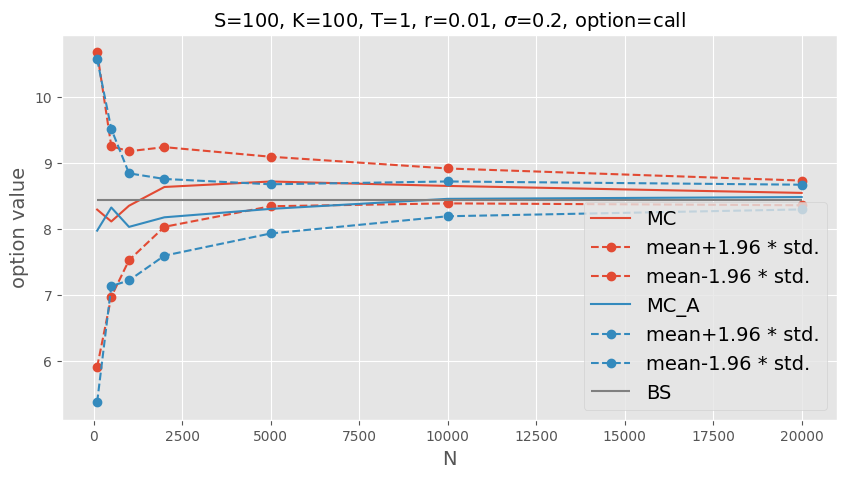

In [75]:
S = 100
K = 100
T = 1
r = 0.01
sigma = 0.2
option = 'call'
bs_res = BS(S, K, T, r, sigma, option)
N = [100, 500, 1000, 2000, 5000, 10000, 20000]
mc_mean = []
mc_std = []
mc_a_mean = []
mc_a_std = []
for n in N:
    m, s = monte_carlo_option(S, K, T, r, sigma, n, option, 'ordinary')
    mc_mean.append(m)
    mc_std.append(s)
    m, s = monte_carlo_option(S, K, T, r, sigma, n, option, 'antithetic')
    mc_a_mean.append(m)
    mc_a_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)
mc_a_mean = np.array(mc_a_mean)
mc_a_std = np.array(mc_a_std)

analysis_N = N
error_df = pd.DataFrame({'N':analysis_N, 'MC':np.abs((mc_mean)-bs_res), 'MC_A':np.abs((mc_a_mean)-bs_res)})
print('=================')
print('Pricing Value')
print('-----------------')
print(f'BS: {bs_res:.3f}')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')
print(f'Monte Carlo (A) mean: {mc_a_mean[-1]:.3f}')
print(f'Monte Carlo (A) std: {mc_a_std[-1]:.3f}')

print('=================')
print('Error Performance')
print('=================')
print(error_df.T)

plt.figure(figsize=(10,5))
plt.plot(N, mc_mean, label='MC')
plt.plot(N, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(N, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')

plt.plot(N, mc_a_mean, label='MC_A')
plt.plot(N, mc_a_mean+1.96*mc_a_std, label='mean+1.96 * std.', color='#348ABD', marker='o', linestyle='--')
plt.plot(N, mc_a_mean-1.96*mc_a_std, label='mean-1.96 * std.', color='#348ABD', marker='o', linestyle='--')

plt.hlines(bs_res, N[0], N[-1], color='gray', label='BS')
plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)

### Chooser Option

In [142]:
def monte_carlo_chooser(S, K, t, T, r, sigma, N, method='ordinary', sd=1234):
    np.random.seed(sd)
    if method == 'ordinary':
        eps = np.random.normal(0, 1, N)
    elif method == 'antithetic':
        eps = np.random.normal(0, 1, int(N/2))
        eps = np.concatenate((eps, -eps))
    St = S * np.exp((r-0.5*sigma**2)*t + sigma*t**0.5*eps)
    np.random.seed(sd+1)
    if method == 'ordinary':
        eps = np.random.normal(0, 1, N)
    elif method == 'antithetic':
        eps = np.random.normal(0, 1, int(N/2))
        eps = np.concatenate((eps, -eps))
    ST = np.array(list(map(lambda s: s * np.exp((r-0.5*sigma**2)*(T-t) + sigma*(T-t)**0.5*eps), St)))
    call_t = np.mean(call(ST, K) * np.exp(-r*(T-t)), axis=1)
    put_t = np.mean(put(ST, K) * np.exp(-r*(T-t)), axis=1)
    payoff_t = np.maximum(call_t, put_t)
    premium = payoff_t * np.exp(-r*t)
    return np.mean(premium), np.std(premium)/N**0.5

def chooser(S, K, t, T, r, sigma):
    return BS(S, K, T, r, sigma, 'call') + BS(S, K*np.exp(-r*(T-t)), t, r, sigma, 'put')

Pricing Value
-----------------
BS: 19.089
Monte Carlo mean: 19.036
Monte Carlo std: 0.075
Monte Carlo (A) mean: 19.100
Monte Carlo (A) std: 0.075
Error Performance
               0           1            2            3            4  \
N     100.000000  500.000000  1000.000000  2000.000000  5000.000000   
MC      1.005712    0.577458     0.486887     0.200454     0.067725   
MC_A    0.082667    0.100611     0.409903     0.368326     0.219578   

                 5             6  
N     10000.000000  20000.000000  
MC        0.028916      0.052557  
MC_A      0.042772      0.011217  


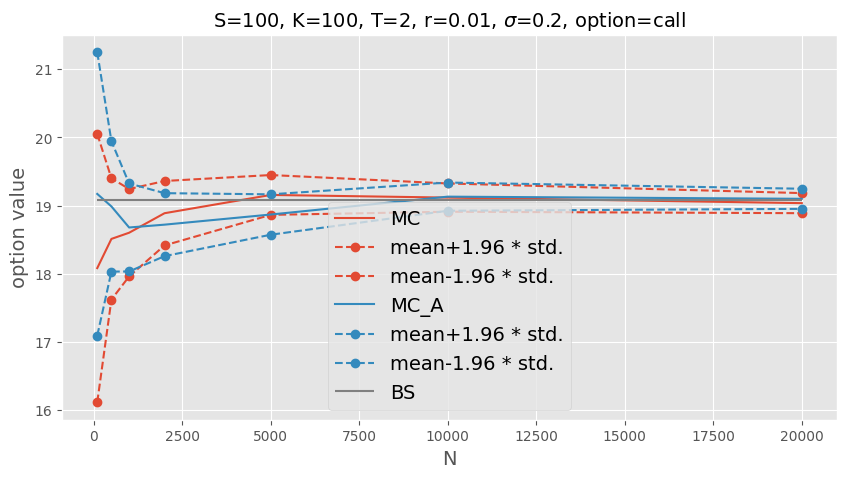

In [144]:
S = 100
K = 100
t = 1
T = 2
r = 0.01
sigma = 0.2
option = 'call'
bs_res = chooser(S, K, t, T, r, sigma)
N = [100, 500, 1000, 2000, 5000, 10000, 20000]
mc_mean = []
mc_std = []
mc_a_mean = []
mc_a_std = []
for n in N:
    m, s = monte_carlo_chooser(S, K, t, T, r, sigma, n, 'ordinary')
    mc_mean.append(m)
    mc_std.append(s)
    m, s = monte_carlo_chooser(S, K, t, T, r, sigma, n, 'antithetic')
    mc_a_mean.append(m)
    mc_a_std.append(s)

mc_mean = np.array(mc_mean)
mc_std = np.array(mc_std)
mc_a_mean = np.array(mc_a_mean)
mc_a_std = np.array(mc_a_std)

analysis_N = N
error_df = pd.DataFrame({'N':analysis_N, 'MC':np.abs((mc_mean)-bs_res), 'MC_A':np.abs((mc_a_mean)-bs_res)})
print('=================')
print('Pricing Value')
print('-----------------')
print(f'BS: {bs_res:.3f}')
print(f'Monte Carlo mean: {mc_mean[-1]:.3f}')
print(f'Monte Carlo std: {mc_std[-1]:.3f}')
print(f'Monte Carlo (A) mean: {mc_a_mean[-1]:.3f}')
print(f'Monte Carlo (A) std: {mc_a_std[-1]:.3f}')

print('=================')
print('Error Performance')
print('=================')
print(error_df.T)

plt.figure(figsize=(10,5))
plt.plot(N, mc_mean, label='MC')
plt.plot(N, mc_mean+1.96*mc_std, label='mean+1.96 * std.', color='#E24A33', marker='o', linestyle='--')
plt.plot(N, mc_mean-1.96*mc_std, label='mean-1.96 * std.', color='#E24A33', marker='o', linestyle='--')

plt.plot(N, mc_a_mean, label='MC_A')
plt.plot(N, mc_a_mean+1.96*mc_a_std, label='mean+1.96 * std.', color='#348ABD', marker='o', linestyle='--')
plt.plot(N, mc_a_mean-1.96*mc_a_std, label='mean-1.96 * std.', color='#348ABD', marker='o', linestyle='--')

plt.hlines(bs_res, N[0], N[-1], color='gray', label='BS')
plt.title(f'S={S}, K={K}, T={T}, r={r}, $\sigma$={sigma}, option={option}', fontsize=14)
plt.xlabel('N', fontsize=14)
plt.ylabel('option value', fontsize=14)
plt.legend(fontsize=14)